In [ ]:
%pip install pandas seaborn geopandas bokeh jupyter_bokeh xyzservices shapely

### Distribution Bubble Map

Plotting population and density for a set of species

The process for this derived from a [CoderzColumn article by Sunny Solanki](https://coderzcolumn.com/tutorials/data-science/geoviews-scatter-and-bubble-maps)

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import h3pandas
import shapely
import seaborn as sns
import matplotlib.pyplot as plt
import xyzservices.providers as xyz
from pathlib import Path

from bokeh.palettes import Reds8
from bokeh.io import output_notebook
from bokeh.plotting import output_file, save, figure, show
from bokeh.layouts import layout
from bokeh.models import TabPanel, Tabs
from bokeh.models import HoverTool, RangeSlider, CustomJS, Dropdown
from bokeh.models import Scatter, LabelSet
from bokeh.models import GeoJSONDataSource, ColumnDataSource

<Axes: >

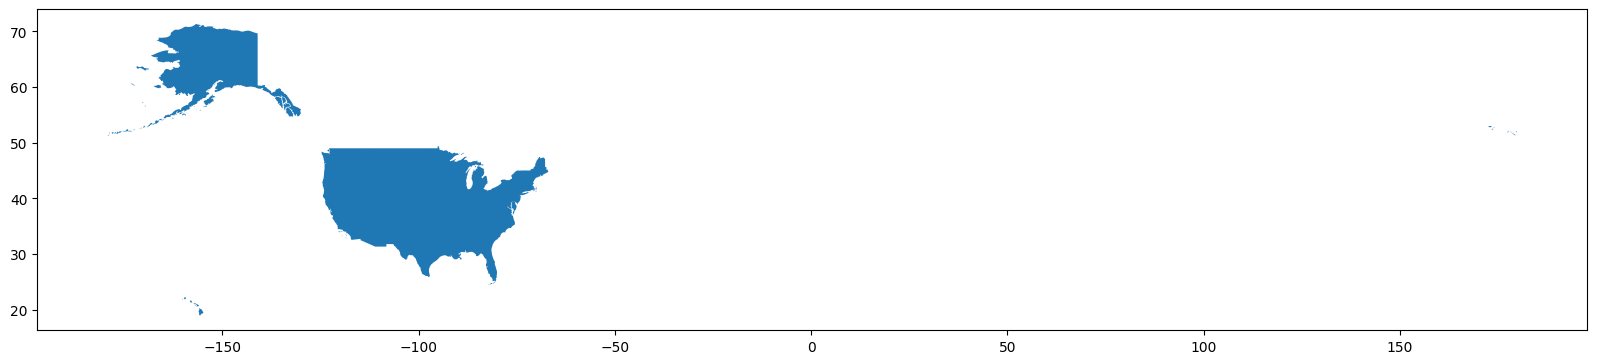

In [3]:
# Import occurrences shapefile

occurrence_gdf = gpd.read_file(Path('../output/occurrences/occurrences.shp'))

# Create a national shape of the United States with just the 50 states

state_shp = gpd.read_file(Path('../dataset/cb_2023_us_all_20m/cb_2023_us_state_20m/cb_2023_us_state_20m.shp'))

exclude = ['American Samoa', 'Commonwealth of the Northern Mariana Islands', 'Puerto Rico', 'United States Virgin Islands', 'Guam']

state_shp = state_shp[~state_shp['NAME'].isin(exclude)]

united_states_shp = state_shp.dissolve()
state_shp = None

united_states_shp.plot(figsize=(20,20))

In [4]:
# Reduce the United States GDF to only the necessary columns

united_states_shp = united_states_shp.drop(columns=['STATEFP', 'STATENS', 'STUSPS', 'LSAD', 'ALAND', 'AWATER', 'GEOIDFQ', 'GEOID', 'NAME'])
united_states_shp

geometry
0  MULTIPOLYGON (((-156.8903 20.74486, -156.90908...

#### H3 Resolutions

- 3: Cell Size = 12,393.435 km^2, about 4,785.132 mi^2
- 4: Cell Size = 1,770.348 km^2, about 516.151 mi^2
- 5: Cell Size = 252.904 km^2, about 73.735 mi^2
- 6: Cell Size = 36.129 km^2, about 10.534 mi^2
- 7: Cell Size = 5.161 km^2, about 1.505 mi^2

In [5]:
# Create the hex grids

united_states_shp = united_states_shp.to_crs(crs='EPSG:4326') # H3 expects WGS84/EPSG:4326 data

# For this plot, we will use a resolution of 3
# This will give a good shape of the USA without being computationally prohibitive

hex_grid = united_states_shp.h3.polyfill_resample(3)

In [6]:
# Calcuate the centers of each hex cell

hex_grid['center'] = shapely.centroid(hex_grid['geometry'])

In [13]:
# Create Dataframes for the populations of each species

species_dataframes = {}
years = sorted(occurrence_gdf['year'].unique())
default_years = (2020, 2024)

counts = occurrence_gdf['verbatName'].value_counts().reset_index()

# Here, we're only going to look at the top 10 species
# However, this can be extended to more 
top_species = counts.head(10)

# If the data files exist on disk, load them
for species in top_species['verbatName']:
  try:
    
    species_occurrences = gpd.read_file(Path(f'../output/bubbles/{species.replace(' ', '-')}.geojson'))

    # Convert columns to numeric types if possible
    for column in species_occurrences.columns:
      try:
        species_occurrences[column] = pd.to_numeric(species_occurrences[column])
      except:
        None

    species_dataframes[species] = species_occurrences.fillna(value=np.nan)
  except:
    None # File likely does not exist, do nothing

# Otherwise, regenerate the hex grids (This will take a long time; consider using lower resolutions)
# Or, change the set of species to use
if len(species_dataframes) == 0:
  for species in top_species['verbatName']:
    species_hex_grid = hex_grid.copy()

    for year in years:
      annual_population = []

      year_df = occurrence_gdf[(occurrence_gdf['year'] == year) & (occurrence_gdf['verbatName'] == species)]

      # If there are no occurrences this year, skip
      if len(year_df) == 0:
        annual_population = [np.nan for x in range(len(species_hex_grid))]
      else:
        for row in species_hex_grid.itertuples():
          species_occurrences = year_df[row.geometry.contains(year_df['geometry'])]

          count = len(species_occurrences)
          if count == 0:
            annual_population.append(np.nan)
          else:
            annual_population.append(count)
    
      species_hex_grid[f'{year}_population'] = annual_population

    species_dataframes[species] = species_hex_grid

  # Calculate a sum between the default years
  filter_years = []
  for year in range(default_years[0], default_years[1] + 1):
    if year in years:
      filter_years.append(f'{year}_population')

  for k, v in species_dataframes.items():
    species_dataframes[k]['population'] = species_dataframes[k][filter_years].sum(axis=1)
  
  # Drop rows where there is no data

  subset_columns = []
  for year in years:
    subset_columns.append(f'{year}_population')

  # If all of the biodiversity columns for a row are null, there is no data
  # so, remove the row
  for k, v in species_dataframes.items():
    species_dataframes[k] = v.dropna(subset=subset_columns, how='all')

  # Drop columns that we don't need
  for k, v in species_dataframes.items():
    species_dataframes[k] = v.reset_index().drop(columns=['geometry', 'h3_polyfill', 'index'])

  # Set the CRS of the species dataframes to WGS84
  # The points were made from this projection, though the CRS is not set

  for k, v in species_dataframes.items():
    species_dataframes[k] = v.set_geometry('center').set_crs('EPSG:4326')

  # Save datasets to files

  for k, v in species_dataframes.items():
    v.to_file(Path(f'../output/bubbles/{k.replace(' ', '-')}.geojson'), driver='GeoJSON')


In [14]:
species_dataframes['Apis mellifera']

1964_population  1990_population  1995_population  1998_population  \
0                NaN              NaN              NaN              NaN   
1                NaN              NaN              NaN              NaN   
2                NaN              NaN              NaN              NaN   
3                NaN              NaN              NaN              NaN   
4                NaN              NaN              NaN              NaN   
..               ...              ...              ...              ...   
127              NaN              NaN              NaN              NaN   
128              NaN              NaN              NaN              NaN   
129              NaN              NaN              NaN              NaN   
130              NaN              NaN              NaN              NaN   
131              NaN              NaN              NaN              NaN   

     1999_population  2001_population  2002_population  2003_population  \
0                NaN              NaN              NaN              NaN   
1                NaN              NaN              2.0              NaN   
2                NaN              NaN              2.0              NaN   
3                NaN              NaN              NaN              NaN   
4                NaN              NaN              NaN              NaN   
..               ...              ...              ...              ...   
127              NaN              NaN              NaN              NaN   
128              NaN              NaN              NaN              NaN   
129              NaN              NaN              NaN              NaN   
130              NaN              NaN              NaN              NaN   
131              NaN              NaN              NaN              NaN   

     2004_population  2005_population  ...  2017_population  2018_population  \
0                NaN              NaN  ...              NaN              NaN   
1                NaN              NaN  ...              NaN              NaN   
2                NaN              NaN  ...              NaN              NaN   
3                NaN              NaN  ...              NaN             19.0   
4                NaN              NaN  ...              NaN              NaN   
..               ...              ...  ...              ...              ...   
127              NaN              NaN  ...              NaN              NaN   
128              NaN              NaN  ...              NaN              NaN   
129              NaN              NaN  ...              NaN              NaN   
130              NaN              NaN  ...              NaN              NaN   
131              NaN              NaN  ...              NaN              NaN   

     2019_population  2020_population  2021_population  2022_population  \
0                NaN              NaN              NaN              NaN   
1                NaN              NaN              NaN              NaN   
2                NaN              NaN              NaN              NaN   
3                8.0              NaN              1.0              NaN   
4                NaN              NaN              NaN              NaN   
..               ...              ...              ...              ...   
127              NaN              NaN              NaN              NaN   
128              NaN              NaN              NaN              NaN   
129              NaN              NaN              NaN              NaN   
130              NaN              NaN              NaN              NaN   
131              NaN              NaN              NaN              NaN   

     2023_population  2024_population  population                     geometry  
0                NaN              NaN         0.0   POINT (-82.61936 34.92165)  
1                NaN              NaN         0.0   POINT (-96.76287 33.36278)  
2                NaN              NaN         0.0   POINT (-67.56612 44.54326)  
3                

Code for creating a glyph size legend was sourced from a [post in the Bokeh forums by gmerritt123](https://discourse.bokeh.org/t/creating-a-legend-for-glyph-size/9587/2)

In [15]:
output_notebook()

Loading BokehJS ...

In [16]:
from bokeh.layouts import layout

def genLegendFigure(input_dict,glyph):
    assert 'Label' in input_dict.keys()
    l = figure(x_range=(-3,10),y_range=(-1*len(input_dict['Label']),1))
    src = ColumnDataSource(input_dict)
    src.data['yleg'] = np.arange(len(input_dict['Label']))*-1
    glyph.x = 0
    glyph.y='yleg'
    r = l.add_glyph(src,glyph)
    lbls = LabelSet(x=2,y='yleg',text='Label',source=src,x_offset=25,y_offset=-10)
    lbl_r = l.add_layout(lbls)
    l.toolbar.logo = None
    l.toolbar_location = None
    l.xgrid.grid_line_color = None
    l.ygrid.grid_line_color = None
    l.yaxis.visible = False
    l.xaxis.visible = False
    return l

input_dict = {'size':[70, 55, 45, 25, 15],'Label':['10000','7500','5000','2500','1000']} 
g = Scatter(size='size',fill_color=Reds8[0]) #the glyph

leg = genLegendFigure(input_dict,g)
leg.height = 800
leg.width = 200
leg.title="Size and Number of Individuals"

# Plot bokeh chart

color = Reds8[0]

# Set size of each dot
for k, v in species_dataframes.items():
  sizes = []

  pop_max = v['population'].max()
  for _, row in v.iterrows():
    try:
      sizes.append(np.sqrt(row['population'] * 2000))
    except ValueError: # Value is NaN
        sizes.append(0)
    
  species_dataframes[k]['size'] = sizes

sources = []

# Duplicate the first source; One will be overwritten while the rest are constant
first_key = next(iter(species_dataframes))

source = (
    GeoJSONDataSource(geojson=species_dataframes[first_key]
    .to_crs(crs='EPSG:3857')
    .to_json())
)

p = figure(
    title="Species Population Density in the USA", 
    x_axis_type="mercator", 
    y_axis_type="mercator",
    toolbar_location='left',
    width=800,
    height=800,
)
p.circle('x', 'y', source=source, fill_color=color, fill_alpha=0.7, line_color = color, line_width = 1, radius='size')
p.add_tools(HoverTool(tooltips=[
    ("Population", "@population"),
], point_policy="follow_mouse"))

p.add_tile(xyz.OpenStreetMap.Mapnik)
p.match_aspect = True

sources.append(source)

menu = [] # Array of (String, String) tuples

# Add the rest of the sources
i = 1
for k, v in species_dataframes.items():
    # Reproject `hexplots_4r` to use the Web Mercator CRS (EPSG 3857)
    # This allows tiling and prevents Alaska's Aleutian Islands from being cut off
    source = GeoJSONDataSource(geojson=v.to_crs(crs='EPSG:3857').to_json())

    menu.append((k, f'{i}'))

    sources.append(source)
    #plots.append(p)
    i += 1

range_js = """
    var data = source[0].data;

    // cb_obj.value[0] // Start Year

    // cb_obj.value[1] // End Year

    var years = [];

    // Get valid years between the range values
    for (var i = 0; i <= cb_obj.value[1] - cb_obj.value[0]; i++) {
        let year = cb_obj.value[0] + i;

        // We only need to check this for one index
        if (`${year}_population` in data) {
            years.push(year);
        }
    }

    // Recalculate the sum population (Sum all valid years)
    // Other indices have the same length as the array used here
    for (var i = 0; i < data.population.length; i++) {
        let sum = 0;

        for (var j = 0; j < years.length; j++) {
            let year = years[j];

            if (!isNaN(data[`${year}_population`][i])) {
                sum += data[`${year}_population`][i];
            }
        }

        data.population[i] = sum;
    }

    // Update glyph sizes
    for (var i = 0; i < data.size.length; i++) {
        if (isNaN(data.population[i])) {
            data.size[i] = 0;
        }
        else {
            data.size[i] = Math.sqrt(data.population[i]) * 2000;
        }
    }

    source[0].data = data

    source[0].change.emit();
"""

button_js = """
    var data = source.data;
    var palette = palette;

    // Simpson Index
    if (btn.active == 0) {
        // Update Colors

        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.simpson_biodiversity[i])) {
                data.color[i] = "black";
            }
            else {
                data.color[i] = palette[Math.floor(data.simpson_biodiversity[i] * 7)];
            }
        }
    }

    // Shannon-Wiener Index
    if (btn.active == 1) {
        // Update Colors
        
        // Get max Shannon-Wiener Index value
        let shannon_max = 0

        for (var i = 0; i < data.shannon_biodiversity.length; i++) {
            if (!isNaN(data.shannon_biodiversity[i])) {
                if (data.shannon_biodiversity[i] > shannon_max) {
                    shannon_max = data.shannon_biodiversity[i]
                }
            }
        }
        
        for (var i = 0; i < data.color.length; i++) {
            if (isNaN(data.shannon_biodiversity[i])) {
                data.color[i] = "black";
            }
            else {
                let proportion = data.shannon_biodiversity[i] / shannon_max
                data.color[i] = palette[Math.floor(proportion * 7)];
            }
        }
    }

    source.change.emit();
"""

dropdown_js = """
    var data = source[this.item].data

    dropdown.label = dropdown.menu[this.item - 1][0]

    source[0].data = data

    source[0].change.emit();
"""

range_slider = RangeSlider(title="Years", start=years[0], end=years[-1], value=default_years, step=1)

range_slider.js_on_change('value', CustomJS(args=dict(source=sources), code = range_js))

dropdown = Dropdown(label="Species Selection", button_type="primary", menu=menu)
dropdown.js_on_event("menu_item_click", CustomJS(args=dict(source=sources, dropdown=dropdown), code=dropdown_js))

layout = layout(
    [range_slider, dropdown],
    [p, leg],
)

show(layout)

In [ ]:
# Save plot to a file
output_file(filename=Path('../charts/distribution_bubblemap.html'), title='Species Population Density in the USA')
save(layout)